In [1]:
import ECGDataset 
import Models 
import Net
from train_test_validat import *
from self_attention import *
import matplotlib.pyplot as plt
import ecg_plot
import cam
import ECGplot
import ECGHandle
import torch
import torch.utils.data as Data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import random
import pandas as pd
from tqdm import tqdm

import time
import math
import os
import gc
from torch.utils.tensorboard import SummaryWriter


def seed_torch(seed=2023):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False 
	torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.enabled = False

In [2]:
EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = "cpu"
seed_torch(2023)

In [3]:
data_root = '/workspace/data/Preprocess_HTN/datas_/'
ALL_data = pd.read_csv(data_root+'/All_data_handled_ID_range_age_IDimputate.csv',low_memory=False)
ALL_data = ECGHandle.change_label(ALL_data)
ALL_data = ECGHandle.filter_ID(ALL_data)
ALL_data = ECGHandle.filter_QC(ALL_data)
ALL_data = ECGHandle.filter_ages(ALL_data,18)
ALL_data = ECGHandle.filter_departmentORlabel(ALL_data,'外科')
ALL_data = ECGHandle.correct_label(ALL_data)
ALL_data = ECGHandle.correct_age(ALL_data)
ALL_data = ECGHandle.filter_diagnose(ALL_data,'起搏')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'房颤')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'左束支传导阻滞')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'左前分支阻滞')
# ALL_data = ECGHandle.filter_diagnose(ALL_data,'阻滞')
# ALL_data = ECGHandle.remove_duplicated(ALL_data)
ALL_data = ALL_data.rename(columns={'住院号':'ID','年龄':'age','性别':'gender','姓名':'name'}) 
ALL_data_buffer = ALL_data.copy()
seed_torch(2023)
ALL_data_buffer = ALL_data_buffer.sample(frac=1).reset_index(drop=True) #打乱顺序
# all_dataset = ECGHandle.ECG_Dataset(data_root,ALL_data_buffer,preprocess = True)
####################################################################随机选取test
test_df,tv_df = Pair_ID(ALL_data,0.2,Range_max=15,pair_num=1)
test_dataset = ECGHandle.ECG_Dataset(data_root,test_df,preprocess = True)



            orginal   removed diagnose NaN
   nums      200082          199997       
              HTN             NHTN        
   nums       3273           196724       


            orginal      removed ID NaN   
   nums      199997          199995       
              HTN             NHTN        
   nums       3273           196722       


            orginal            QC         
   nums      199995          72845        
              HTN             NHTN        
   nums       1497           71348        


            orginal      filtered ages    
   nums      72845           69819        
              HTN             NHTN        
   nums       1477           68342        


            orginal   filtered department 
   nums      69819           15344        
              HTN             NHTN        
   nums       1477           13867        


     reset num:       10  
  ERR labels num:     27  
            orginal      correct label    
   nums      15344           15

In [4]:
Models_path = '/workspace/data/Interpretable_HTN/model/20230319_151031/20230319_151031/BestF1_4.pt'
save_root = Models_path[:-3]+'/'    
layervalue_root = save_root+'/layervalue/'    
NET = [Net.MLBFNet_GUR_o(True,True,True,2,Dropout_rate=0.3), ] # type: ignore    
criterion = torch.nn.CrossEntropyLoss()    
testmodel = NET[0].to(DEVICE)    
testmodel.load_state_dict(torch.load(Models_path))    
test_dataloader = Data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)      
y_true,y_pred,y_out,test_loss,test_acc = eval_model(test_dataloader,criterion,testmodel,DEVICE) # 验证模型

In [5]:
optimal_th = 0.5 #根据验证集得到的，不能在测试集上找,或者直接设置成0.5
y_pred = ((np.array(y_out))[:,1])
y_pred[y_pred>optimal_th] =  int(1)
y_pred[y_pred<=optimal_th] =  int(0)
F1_score_valid =f1_score(y_true, y_pred, average='binary')#F1分数
p_valid = precision_score(y_true, y_pred, average='binary')
r_valid = recall_score(y_true, y_pred, average='binary')   
auc_valid = roc_auc_score(y_true,y_score=((np.array(y_out))[:,1]))
C1 = confusion_matrix(y_true,y_pred)
print(   '\n',C1[0],'\n',C1[1],'\n',"F1_score: ",F1_score_valid,'\n',"precision: ",p_valid,'\n',"recall: ",r_valid,'AUC',auc_valid)


 [225  38] 
 [ 42 229] 
 F1_score:  0.8513011152416358 
 precision:  0.8576779026217228 
 recall:  0.8450184501845018 AUC 0.9132350258863806


In [6]:
# 定义获取梯度的函数
fmap_block = list()
grad_block = list()

# 获取反向的传播图
def backward_hook(module, grad_in, grad_out):
    # print('backward_hook ',len(grad_out),grad_out[0].shape)
    grad_block.append(grad_out[0].clone().cpu().detach())

# 定义获取特征图的函数
def farward_hook(module, input, output):
    # print('farward_hook ',output.shape)
    fmap_block.append(output.clone().cpu().detach())

In [7]:
def scaled_layer_cam(x,gamma:float = 2.):
    x_max = x.max()
    x_scaled = np.tanh(((gamma*x)/x_max))
    return x_scaled

In [53]:
def scaled_layer_cam_max(cam):
    (cam_min, cam_max) = (cam.min(), cam.max())
    norm_cam = (cam - cam_min) / (((cam_max - cam_min) + 1e-08))
    return norm_cam
def scaled_layer_cam_tanh(cam,gamma = 2.):
    (cam_min, cam_max) = (cam.min(), cam.max())
    norm_cam = np.tanh(gamma*cam/cam_max)
    return norm_cam

In [72]:
save_root = Models_path[:-3]+'/'
layervalue_root = save_root+'/layervalue/'
if(not(os.path.exists(save_root))): os.mkdir(save_root)
if(not(os.path.exists(layervalue_root))): os.mkdir(layervalue_root)
lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
x_index = np.arange(0,12)
# fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True,sharey=True,figsize=(45,25), constrained_layout=True,dpi =100)
for index in tqdm(range( test_dataset.__len__())):# test_dataset.__len__()
    NET = [Net.MLBFNet_GUR_o(True,True,True,2,Dropout_rate=0.3), ] # type: ignore
    testmodel = NET[0].to(DEVICE)
    testmodel.load_state_dict(torch.load(Models_path))
    testmodel.conv1.register_forward_hook(farward_hook)	#正向传播
    testmodel.conv1.register_full_backward_hook(backward_hook)#反向传播
    testmodel.conv2.register_forward_hook(farward_hook)	#正向传播
    testmodel.conv2.register_full_backward_hook(backward_hook)#反向传播
    testmodel.layers_list_2d[0].register_forward_hook(farward_hook)	#正向传播
    testmodel.layers_list_2d[0].register_full_backward_hook(backward_hook)#反向传播
    testmodel.layers_list_2d[1].register_forward_hook(farward_hook)	#正向传播
    testmodel.layers_list_2d[1].register_full_backward_hook(backward_hook)#反向传播
    testmodel.layers_list_2d[2].register_forward_hook(farward_hook)	#正向传播
    testmodel.layers_list_2d[2].register_full_backward_hook(backward_hook)#反向传播


    inputs,labels = test_dataset.__getitem__(index)
    info =test_dataset.infos.iloc[index]
    ECGfile_name = info['ECGFilename']
    testmodel.eval()
    fmap_block = list()
    grad_block = list()

    labels = labels.unsqueeze(0) # 在首位添加1维作为batchsize
    inputs = inputs.unsqueeze(0) # 在首位添加1维作为batchsize

    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)  

    outputs = testmodel(inputs)
    # print('outputs',outputs)
    _,pred = outputs.max(1)     # 求概率最大值对应的标签
    possibility = nn.functional.softmax(outputs,dim=-1)
    # print("labels: {}".format(labels))
    # print("predict: {}".format(pred))
    # print("possibility: {}".format(possibility))
    loss = outputs[0,pred]      # 网络对应于pred的类别的输出即为loss
    loss.backward(retain_graph=True)  #retain_graph=True，目的为是为保留该过程中计算的梯度，后续G网络更新时使用

    fmap1 = (fmap_block[0][0]).to('cpu').detach().numpy()
    gradmap1 = (grad_block[4][0]).to('cpu').detach().numpy()#G是从后往前的，conv1的在后面
    layer2d_vlue1 = cam.caculate_layer_cam_vlue_2d(fmap1,gradmap1)

    fmap2 = (fmap_block[1][0]).to('cpu').detach().numpy()
    gradmap2 = (grad_block[3][0]).to('cpu').detach().numpy()
    layer2d_vlue2 = cam.caculate_layer_cam_vlue_2d(fmap2,gradmap2)

    fmap2d_1 = (fmap_block[2][0]).to('cpu').detach().numpy()
    gradmap2d_1 = (grad_block[2][0]).to('cpu').detach().numpy()
    layer2d_vlue2d_1 = cam.caculate_layer_cam_vlue_2d(fmap2d_1,gradmap2d_1)

    fmap2d_2 = (fmap_block[3][0]).to('cpu').detach().numpy()
    gradmap2d_2 = (grad_block[1][0]).to('cpu').detach().numpy()
    layer2d_vlue2d_2 = cam.caculate_layer_cam_vlue_2d(fmap2d_2,gradmap2d_2)

    fmap2d_3 = (fmap_block[4][0]).to('cpu').detach().numpy()
    gradmap2d_3 = (grad_block[0][0]).to('cpu').detach().numpy()
    layer2d_vlue2d_3 = cam.caculate_layer_cam_vlue_2d(fmap2d_3,gradmap2d_3)

    layer_vlue_mean = (scaled_layer_cam_max(layer2d_vlue1)+scaled_layer_cam_max(layer2d_vlue2)+scaled_layer_cam_max(layer2d_vlue2d_1)+scaled_layer_cam_max(layer2d_vlue2d_2)+scaled_layer_cam_max(layer2d_vlue2d_3))/5
    np.save(layervalue_root+ECGfile_name,layer_vlue_mean)
    
#     inputs,_ = test_dataset.__getitem__(index)
#     cmap = 'OrRd' 
#     colors = ECGplot.color_map(layer_vlue_mean, cmap)#相当于归一化

#     for i,ax in enumerate(axs.flat):  # type: ignore
#         plot_y = np.array(inputs[i]*5000.)#缩放
#         t = np.arange(0,5000)
#         ECGplot.plot_ECG_line(fig,ax,x = t,y= plot_y,y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i])
#         for j in t:
#             ax.axvline(x=j,alpha=0.1,color=colors[i,j]) #第i导联 第j个时间点的importance value
#     plt.savefig(save_root+'/'+info['ECGFilename']+'_'+str(labels[0].tolist())+'_'+str(pred[0].tolist())+'.png', bbox_inches='tight',dpi = 200)  
# plt.close()  

100%|██████████| 534/534 [17:44<00:00,  1.99s/it]


In [73]:
from scipy import signal

def segement_upsample(segement:np.ndarray,segement_num:int = 10):
    chanle_num = segement.shape[0]
    segement = torch.DoubleTensor(segement).unsqueeze(0).unsqueeze(0)# type: ignore    
    upsampler = nn.Upsample(size=(chanle_num,segement_num),  mode='bilinear',align_corners=False)
    segement_upsampled = upsampler(segement)
    return np.array(segement_upsampled.squeeze(0).squeeze(0))
    
def leads_layervalue_segement_count_upsample(start_index:int,end_index:int,layervalue:np.ndarray,segement_num:int = 10):
    len_ = end_index-start_index
    if(len_<=0):
        print('err')
        return 0
    chanle_num = layervalue.shape[0]
    layervalue_sum = np.zeros([chanle_num,segement_num])
    if(len_<segement_num): #如果长度小于需要分割的长度的话，需要上采样
        # print((layervalue[:,start_index:end_index]))
        segement_value = segement_upsample(layervalue[:,start_index:end_index] ,segement_num)#插值成segement_num步
        # print((segement_value))
        return segement_value
        
    else:
        step = len_//segement_num
        for i in range(segement_num):
            start = start_index+step*i
            sum_sement = layervalue[:,start:(start+step)].sum(axis = 1)/(step*1.0)
            layervalue_sum[:,i] = sum_sement*1. #在这一段step里面，每个时间点的平均重要程度
        return layervalue_sum
    
def leads_layervalue_segement_count(start_index:int,end_index:int,layervalue:np.ndarray,segement_num:int = 10):
    len_ = end_index-start_index
    if(len_<=0):
        print('err')
        return 0
    chanle_num = layervalue.shape[0]
    layervalue_sum = np.zeros([chanle_num,segement_num])
    if(len_<segement_num): #如果长度小于需要分割的长度的话，就取每一导联的平均值
        for i in range(segement_num):
           layervalue_sum[:,i] = layervalue_sum[:,i] + ((layervalue[:,start_index:end_index].sum(axis = 1))/(segement_num*1.0)) #返回每一导联的平均值，广播效应
        return layervalue_sum
    else:
        step = len_//segement_num
        for i in range(segement_num):
            start = start_index+step*i
            sum_sement = layervalue[:,start:(start+step)].sum(axis = 1)/(chanle_num*step*1.0)
            layervalue_sum[:,i] = layervalue_sum[:,i]+sum_sement*1. #在这一段step里面，每个时间点的平均重要程度
        return layervalue_sum
    
def max_min(x):
    max_ = x.max()
    min_ = x.min()
    x_ = (x-min_)/(max_-min_+1e-8)
    return x_

def isoline_correction(ECG:np.ndarray):
    ecg_data = ECG
    for lead in range(ECG.shape[0]):
        b, a = signal.butter(8, 0.01, 'lowpass')   #配置滤波器 8 表示滤波器的阶数
        ecg_outline_data = signal.filtfilt(b, a, ecg_data[lead])  #data为要过滤的信号
        ecg_norm_data = ecg_data - ecg_outline_data
        avg = sum(ecg_data[lead])/len(ecg_data[lead])
        for i in range(len(ecg_data[lead])):
            ecg_data[lead][i] = ecg_data[lead][i] - avg
    return ecg_data

In [74]:
waves_location_file_root = '/workspace/data/Preprocess_HTN/datas_/Wave/'
select_list =['P_start', 'P_peak','Q_start', 'Q_peak', 'R_peak', 'S_peak', 'S_end','T_start', 'T_peak', 'T_end']
segement_num = 100 # 共6个片段，每段划分成10份

important_values = np.zeros([len(select_list)-1,12,segement_num]) #
ECG_values = np.zeros([len(select_list)-1,12,segement_num])

sample_count = 0
for index in range(test_dataset.__len__()):#test_dataset.__len__()
   
    important_value = np.zeros([len(select_list)-1,12,segement_num])
    ECG_value = np.zeros([len(select_list)-1,12,segement_num])
    
    info =test_dataset.infos.iloc[index]
    ECG,labels = test_dataset.__getitem__(index)
    ECG_dignose_isoline = isoline_correction(np.array(ECG))
    if(labels != y_true[index]): 
        break
    pred = y_pred[index]
    if(((pred == labels) and (pred == 1))): 
        
        ECGfile_name = info['ECGFilename']
        layervalue_file = layervalue_root  + ECGfile_name +'.npy'
        waves = np.load(waves_location_file_root+'/FPT/'+ECGfile_name+'.npy')
        layervalue = np.load(layervalue_file)
        waves_ = pd.DataFrame(waves[1:-1],columns=['P_start', 'P_peak', 'P_end','Q_start', 'Q_peak', 'R_peak', 'S_peak', 'S_end','J','T_start', 'T_peak', 'T_end','res0'])
        waves = waves_[select_list].copy()
        if(waves.isnull().any().any()):
            continue
        for bet in range(len(waves.index)):
            
            for peak in range(len(waves.columns)-1):
                start = int(waves.loc[bet][peak])
                end = int(waves.loc[bet][peak+1])
                if (start >= end): continue
                important_value[peak] = important_value[peak] + leads_layervalue_segement_count_upsample(start,end,layervalue,segement_num)
                ECG_value[peak] = ECG_value[peak]+ leads_layervalue_segement_count_upsample(start,end,ECG_dignose_isoline,segement_num)
                
        ECG_value = ECG_value/len(waves.index)#按心拍数平均一下 
        # ECG_value_leads_max = ECG_value.swapaxes(0,1).reshape([12,-1]).max(1).reshape([12,1]) #每个导联归一化
        # ECG_value_leads_min = ECG_value.swapaxes(0,1).reshape([12,-1]).min(1).reshape([12,1])
        # ECG_value = ((ECG_value.swapaxes(0,1).reshape([12,-1])-ECG_value_leads_min)/(ECG_value_leads_max-ECG_value_leads_min)).reshape([12,len(select_list)-1,segement_num]).swapaxes(0,1)
        ECG_values = ECG_values +ECG_value
    
        important_value = important_value/len(waves.index)#按心拍数平均一下
        # important_value_leads_max = important_value.swapaxes(0,1).reshape([12,-1]).max(1).reshape([12,1])#每个导联归一化
        # important_value_leads_min = important_value.swapaxes(0,1).reshape([12,-1]).min(1).reshape([12,1])
        # important_value = ((important_value.swapaxes(0,1).reshape([12,-1])-important_value_leads_min)/(important_value_leads_max-important_value_leads_min)).reshape([12,len(select_list)-1,segement_num]).swapaxes(0,1)
        important_value = max_min(important_value)
        important_values = important_values + important_value
        sample_count = sample_count +1
HTN_important_values = important_values/sample_count #按样本数平均一下
HTN_ECG_values = ECG_values/sample_count
print(sample_count)

229


In [75]:
waves_location_file_root = '/workspace/data/Preprocess_HTN/datas_/Wave/'
select_list =['P_start', 'P_peak','Q_start', 'Q_peak', 'R_peak', 'S_peak', 'S_end','T_start', 'T_peak', 'T_end']
segement_num = 100 # 共6个片段，每段划分成10份

important_values = np.zeros([len(select_list)-1,12,segement_num]) #
ECG_values = np.zeros([len(select_list)-1,12,segement_num])

sample_count = 0
for index in range(test_dataset.__len__()):#test_dataset.__len__()
   
    important_value = np.zeros([len(select_list)-1,12,segement_num])
    ECG_value = np.zeros([len(select_list)-1,12,segement_num])
    
    info =test_dataset.infos.iloc[index]
    ECG,labels = test_dataset.__getitem__(index)
    ECG_dignose_isoline = isoline_correction(np.array(ECG))
    if(labels != y_true[index]): 
        break
    pred = y_pred[index]
    if(((pred == labels) and (pred == 0))): 
        
        ECGfile_name = info['ECGFilename']
        layervalue_file = layervalue_root  + ECGfile_name +'.npy'
        waves = np.load(waves_location_file_root+'/FPT/'+ECGfile_name+'.npy')
        layervalue = np.load(layervalue_file)
        waves_ = pd.DataFrame(waves[1:-1],columns=['P_start', 'P_peak', 'P_end','Q_start', 'Q_peak', 'R_peak', 'S_peak', 'S_end','J','T_start', 'T_peak', 'T_end','res0'])
        waves = waves_[select_list].copy()
        if(waves.isnull().any().any()):
            continue
        for bet in range(len(waves.index)):
            
            for peak in range(len(waves.columns)-1):
                start = int(waves.loc[bet][peak])
                end = int(waves.loc[bet][peak+1])
                if (start >= end): continue
                important_value[peak] = important_value[peak] + leads_layervalue_segement_count_upsample(start,end,layervalue,segement_num)
                ECG_value[peak] = ECG_value[peak]+ leads_layervalue_segement_count_upsample(start,end,ECG_dignose_isoline,segement_num)
                
        ECG_value = ECG_value/len(waves.index)#按心拍数平均一下 
        # ECG_value_leads_max = ECG_value.swapaxes(0,1).reshape([12,-1]).max(1).reshape([12,1]) #每个导联归一化
        # ECG_value_leads_min = ECG_value.swapaxes(0,1).reshape([12,-1]).min(1).reshape([12,1])
        # ECG_value = ((ECG_value.swapaxes(0,1).reshape([12,-1])-ECG_value_leads_min)/(ECG_value_leads_max-ECG_value_leads_min)).reshape([12,len(select_list)-1,segement_num]).swapaxes(0,1)
        ECG_values = ECG_values +ECG_value
    
        important_value = important_value/len(waves.index)#按心拍数平均一下
        # important_value_leads_max = important_value.swapaxes(0,1).reshape([12,-1]).max(1).reshape([12,1])#每个导联归一化
        # important_value_leads_min = important_value.swapaxes(0,1).reshape([12,-1]).min(1).reshape([12,1])
        # important_value = ((important_value.swapaxes(0,1).reshape([12,-1])-important_value_leads_min)/(important_value_leads_max-important_value_leads_min)).reshape([12,len(select_list)-1,segement_num]).swapaxes(0,1)
        important_value = max_min(important_value)
        important_values = important_values + important_value
        sample_count = sample_count +1
NHTN_important_values = important_values/sample_count #按样本数平均一下
NHTN_ECG_values = ECG_values/sample_count
print(sample_count)

225


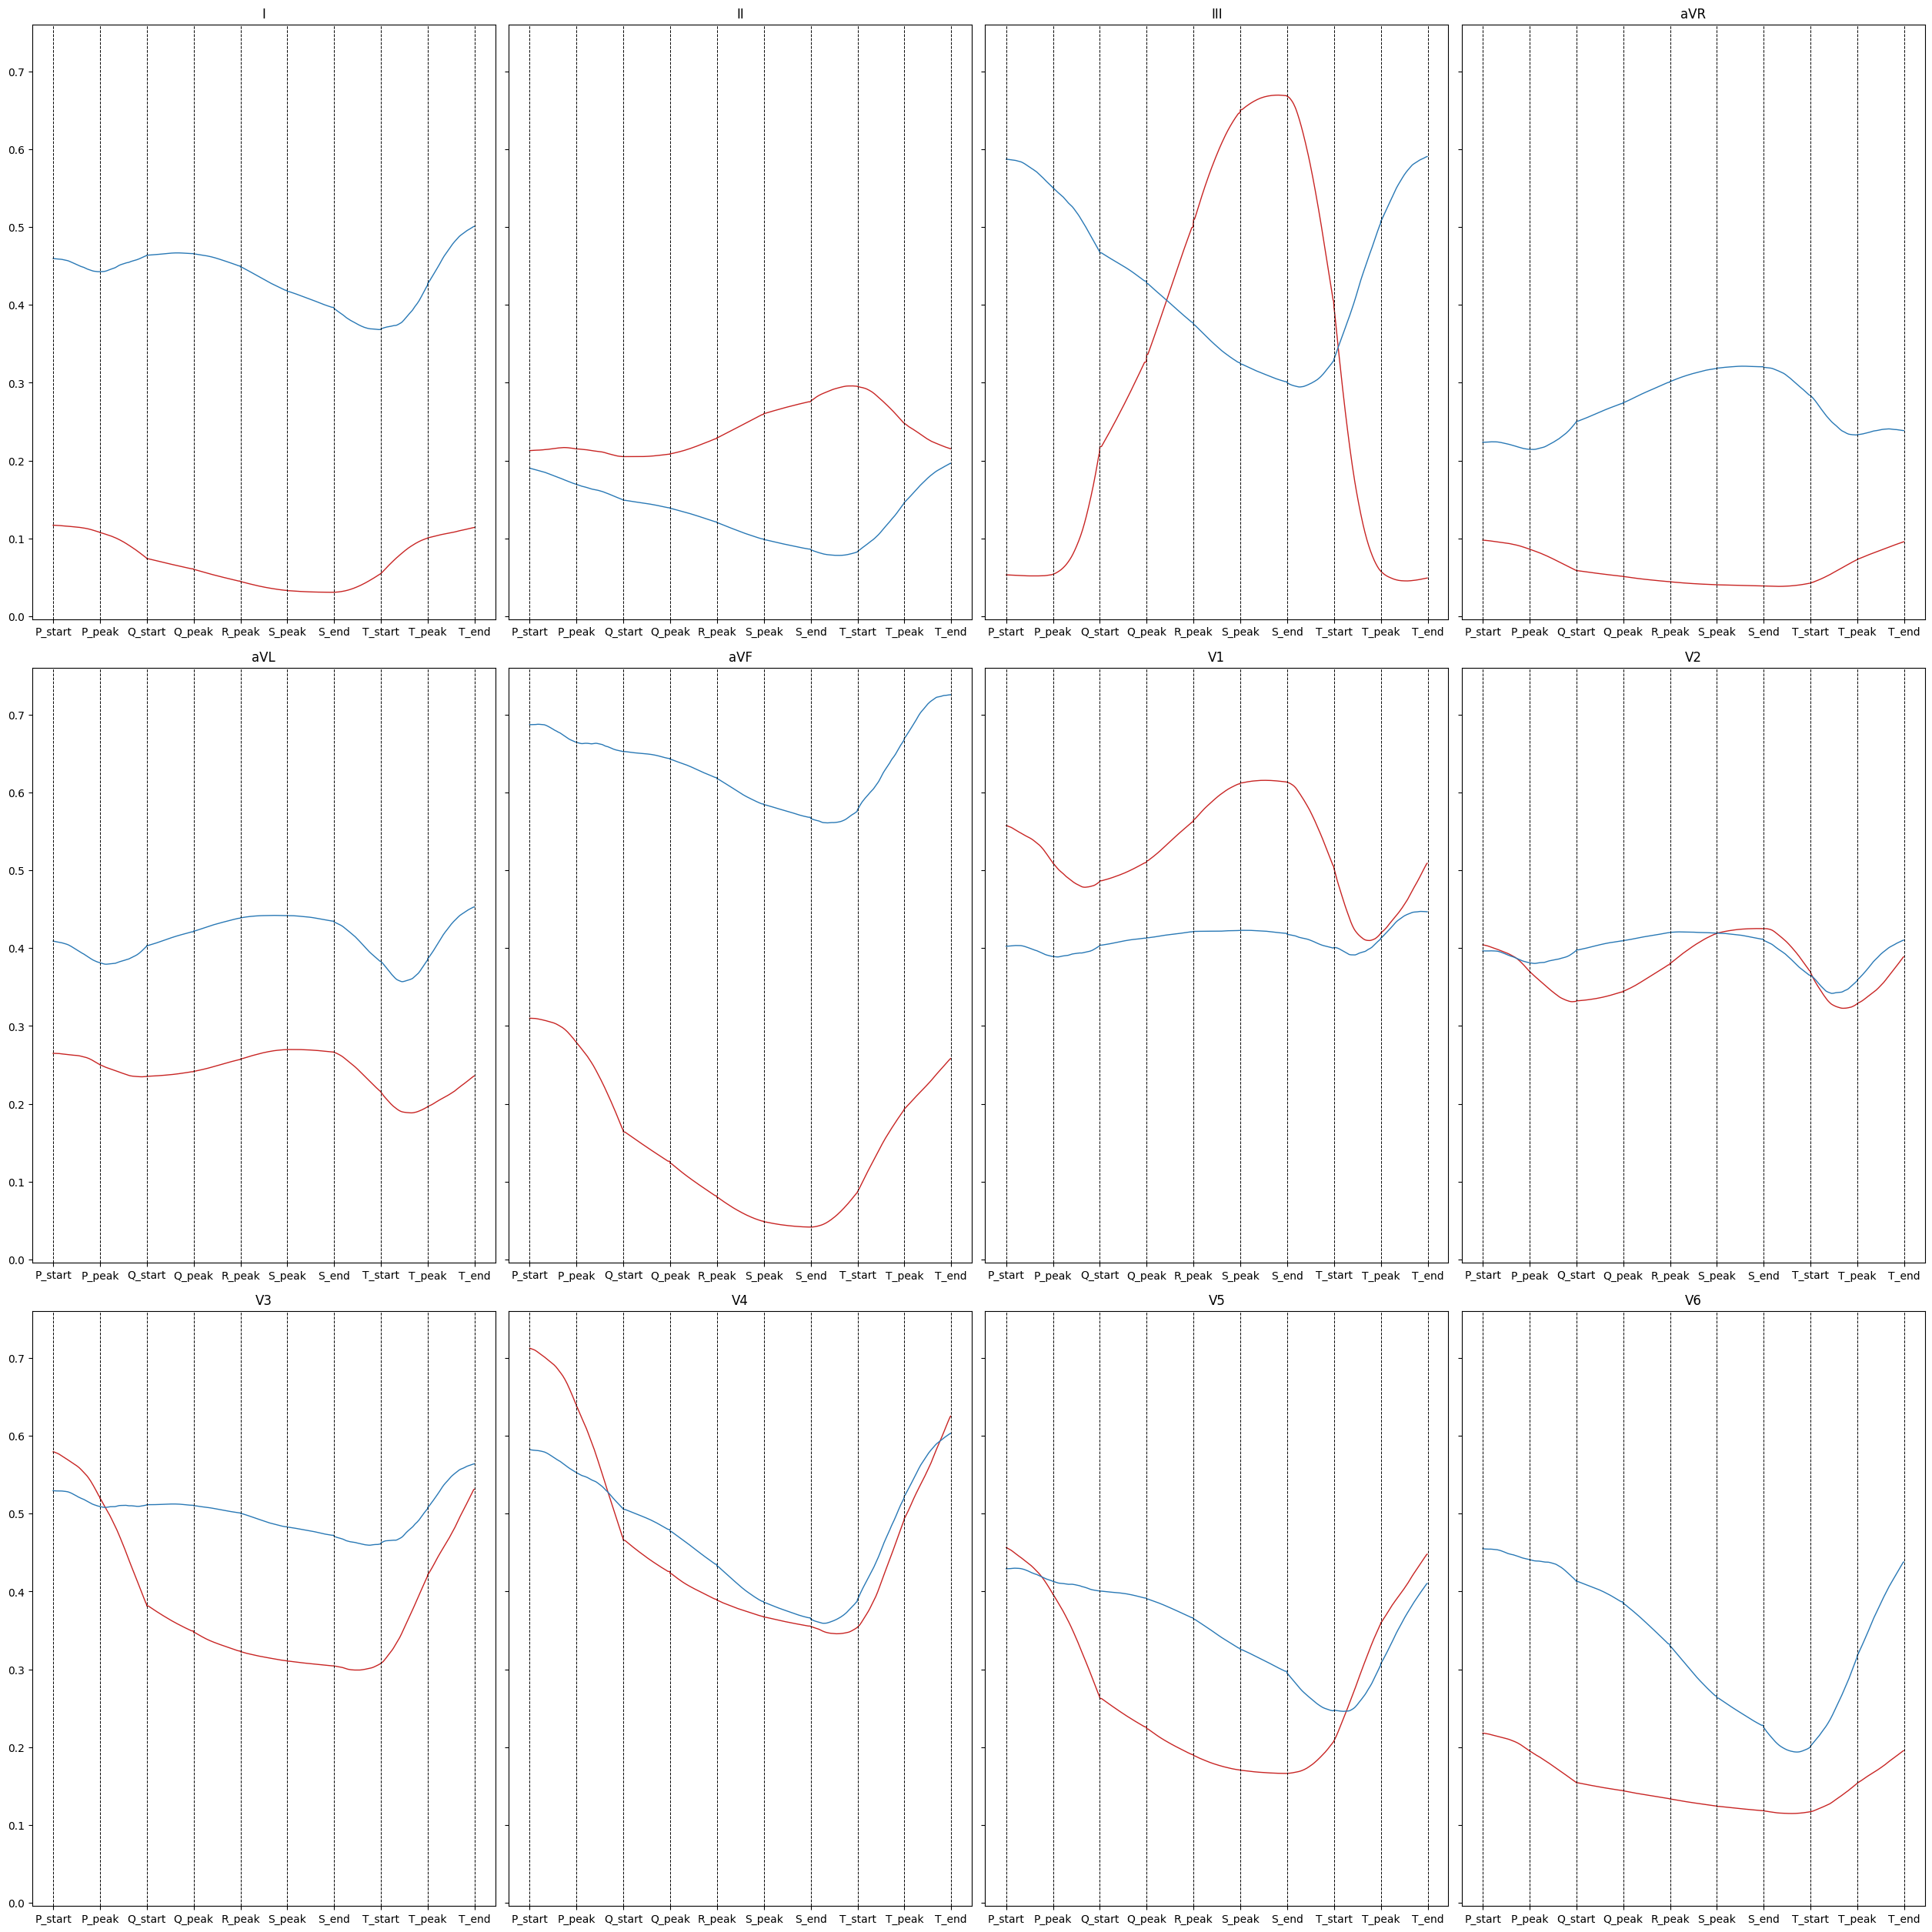

In [76]:
lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
xticks_list = list(np.arange(0,len(select_list)*segement_num,segement_num))

fig, axs = plt.subplots(nrows=3, ncols=4,sharey=True,figsize=(25,25), constrained_layout=True,dpi =100)

HTN_colors = ECGplot.color_map(((HTN_important_values.reshape([12,-1]))), 'autumn')#相当于归一化
NHTN_colors = ECGplot.color_map(((NHTN_important_values.reshape([12,-1]))), 'YlGnBu')#相当于归一化
for i,ax in enumerate(axs.flat):  # type: ignore
    HTN_plot_y = np.array(HTN_ECG_values[:,i,:].flatten())
    HTN_colors_z = np.array(HTN_important_values[:,i,:].flatten())
    NHTN_plot_y = np.array(NHTN_ECG_values[:,i,:].flatten())
    NHTN_colors_z = np.array(NHTN_important_values[:,i,:].flatten())    
    t = np.arange(0,HTN_plot_y.shape[0]) #  
    # ax.plot(t, (HTN_plot_y), lw=1,color='r')
    # ax.plot(t, (NHTN_plot_y), lw=1,color='b')
    
    ax.plot(t, (HTN_colors_z), lw=1,color='#C82423')
    ax.plot(t, (NHTN_colors_z), lw=1,color='#2878B5') 
    
    for j in range(len(select_list)):
        ax.axvline(x=int(xticks_list[j]),ls='dashed',lw=0.7,color='k')
        
    ax.set_xticks(xticks_list) # 设置刻度
    ax.set_xticklabels(select_list)
    ax.set_title(lead_index[i])

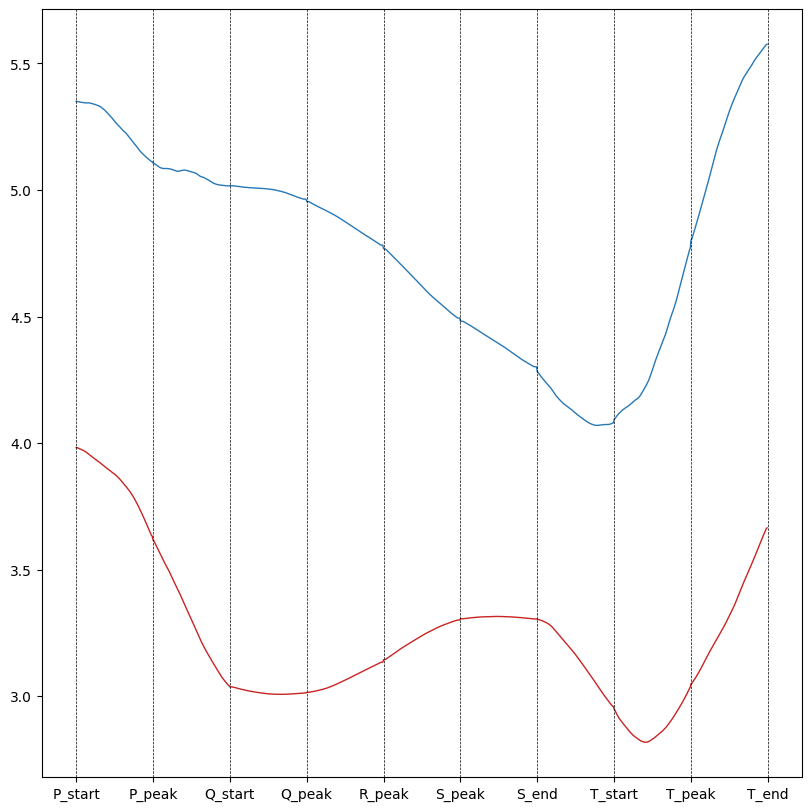

In [79]:
lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
xticks_list = list(np.arange(0,len(select_list)*segement_num,segement_num))

fig, axs = plt.subplots(nrows=1, ncols=1,sharey=True,figsize=(8,8), constrained_layout=True,dpi =100)    

HTN_colors_z = np.array((HTN_important_values.sum(axis=1))).flatten()
NHTN_colors_z = np.array((NHTN_important_values.sum(axis=1))).flatten()   

t = np.arange(0,HTN_colors_z.shape[0]) #  
axs.plot(t, (HTN_colors_z), lw=1,color='#C82423')
axs.plot(t, (NHTN_colors_z), lw=1,color='#2878B5') 
axs.set_xticks(xticks_list) # 设置刻度
axs.set_xticklabels(select_list)
for j in range(len(select_list)):
    axs.axvline(x=int(xticks_list[j]),ls='dashed',lw=0.5,color='k')

## old

In [43]:
def layervalue_segement_count(start_index:int,end_index:int,layervalue:np.ndarray,segement_num:int = 10):
    len_ = end_index-start_index
    chanle_num = layervalue.shape[0]
    if(len_<segement_num):
        layervalue_sum = ((layervalue[:,start_index:end_index].sum())/(chanle_num*segement_num*1.0))
        return layervalue_sum
    step = len_//segement_num
    layervalue_sum = np.zeros(segement_num)
    for i in range(segement_num):
        start = start_index+step*i
        sum_sement = layervalue[:,start:(start+step)].sum()/(chanle_num*step*1.0)
        layervalue_sum[i] = layervalue_sum[i]+sum_sement*1. #在这一段step里面，每个时间点的平均重要程度
    return layervalue_sum

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator


[Text(-10.0, 0, '0'),
 Text(0.0, 0, 'T'),
 Text(10.0, 0, 'P'),
 Text(20.0, 0, 'Q'),
 Text(30.0, 0, 'R'),
 Text(40.0, 0, 'S'),
 Text(50.0, 0, 'T'),
 Text(60.0, 0, 'P'),
 Text(70.0, 0, '')]

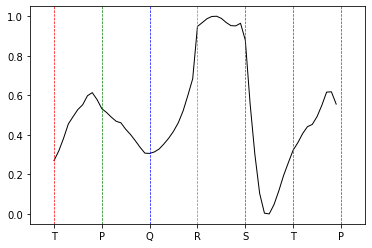

In [44]:
index = 0
segement_number = 10
important_values = np.zeros([6,segement_number])


for index in range(test_dataset.__len__()):#
    important_value = np.zeros([6,segement_number])
    inputs,labels = test_dataset.__getitem__(index)
    if(labels == 0): continue
    info =test_dataset.infos.iloc[index]
    ECGfile_name = info['ECGFilename']
    layervalue_file = layervalue_root  + ECGfile_name +'.npy'
    waves_location_file_root = '/workspace/data/Preprocess_HTN/Waves_2023/'
    waves = pd.read_csv(waves_location_file_root+ECGfile_name+'.csv',index_col=0)
    if(waves.isnull().any().any()):
        continue
    layervalue = np.load(layervalue_file)

    for head_peak in range(1,len(waves.columns)-1):
        if(waves.loc['P'][head_peak] == waves.iloc[:,head_peak].min()): #P波不是第一个识别出来的波形
            p_index = int(waves.loc['P'][head_peak])
            q_index = int(waves.loc['Q'][head_peak])
            r_index = int(waves.loc['R'][head_peak])
            s_index = int(waves.loc['S'][head_peak])
            t_index = int(waves.loc['T'][head_peak])
            t_index_befort = int(waves.loc['T'][head_peak-1])
            if(((waves.loc['P'][head_peak+1]==None)) or((waves.loc['P'][head_peak+1] < t_index))):
                break
            else:
                p_index_next = waves.loc['P'][head_peak+1] 
            important_value[0] = important_value[0]+ layervalue_segement_count(t_index_befort,p_index,layervalue,segement_number)
            important_value[1] = important_value[1]+ layervalue_segement_count(p_index,q_index,layervalue,segement_number)   
            important_value[2] = important_value[2]+ layervalue_segement_count(q_index,r_index,layervalue,segement_number) 
            important_value[3] = important_value[3]+layervalue_segement_count(r_index,s_index,layervalue,segement_number)
            important_value[4] = important_value[4]+ layervalue_segement_count(s_index,t_index,layervalue,segement_number) 
            important_value[5] = important_value[5]+ layervalue_segement_count(t_index,p_index_next,layervalue,segement_number) 
        else:
            break
    important_value = max_min(important_value)
    important_values = important_values + important_value
X_lable = ['0','T','P','Q','R','S','T','P','']
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(important_values.flatten().__len__()), max_min(important_values.flatten()), lw=1,color='k')
ax.axvline(x=0,ls='dashed',lw=0.7,color='r')
ax.axvline(x=10,ls='dashed',lw=0.7,color='g')
ax.axvline(x=20,ls='dashed',lw=0.7,color='b')
ax.axvline(x=30,ls='dashed',lw=0.7,color='c')
ax.axvline(x=40,ls='dashed',lw=0.7,color='m')
ax.axvline(x=50,ls='dashed',lw=0.7,color='r')
ax.axvline(x=60,ls='dashed',lw=0.7,color='g')
ax.set_xlim(-5,65)
ax.set_xticklabels(X_lable)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator


[Text(-10.0, 0, '0'),
 Text(0.0, 0, 'T'),
 Text(10.0, 0, 'P'),
 Text(20.0, 0, 'Q'),
 Text(30.0, 0, 'R'),
 Text(40.0, 0, 'S'),
 Text(50.0, 0, 'T'),
 Text(60.0, 0, 'P'),
 Text(70.0, 0, '')]

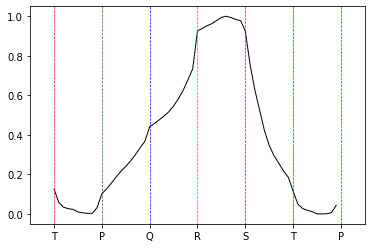

In [45]:
index = 0
segement_number = 10
important_values = np.zeros([6,segement_number])


for index in range(test_dataset.__len__()):#
    important_value = np.zeros([6,segement_number])
    inputs,labels = test_dataset.__getitem__(index)
    if(labels == 1): continue
    info =test_dataset.infos.iloc[index]
    ECGfile_name = info['ECGFilename']
    layervalue_file = layervalue_root  + ECGfile_name +'.npy'
    waves_location_file_root = '/workspace/data/Preprocess_HTN/Waves_2023/'
    waves = pd.read_csv(waves_location_file_root+ECGfile_name+'.csv',index_col=0)
    if(waves.isnull().any().any()):
        continue
    layervalue = np.load(layervalue_file)

    for head_peak in range(1,len(waves.columns)-1):
        if(waves.loc['P'][head_peak] == waves.iloc[:,head_peak].min()): #P波不是第一个识别出来的波形
            p_index = int(waves.loc['P'][head_peak])
            q_index = int(waves.loc['Q'][head_peak])
            r_index = int(waves.loc['R'][head_peak])
            s_index = int(waves.loc['S'][head_peak])
            t_index = int(waves.loc['T'][head_peak])
            t_index_befort = int(waves.loc['T'][head_peak-1])
            if(((waves.loc['P'][head_peak+1]==None)) or((waves.loc['P'][head_peak+1] < t_index))):
                break
            else:
                p_index_next = waves.loc['P'][head_peak+1] 
            important_value[0] = important_value[0]+ layervalue_segement_count(t_index_befort,p_index,layervalue,segement_number)
            important_value[1] = important_value[1]+ layervalue_segement_count(p_index,q_index,layervalue,segement_number)   
            important_value[2] = important_value[2]+ layervalue_segement_count(q_index,r_index,layervalue,segement_number) 
            important_value[3] = important_value[3]+layervalue_segement_count(r_index,s_index,layervalue,segement_number)
            important_value[4] = important_value[4]+ layervalue_segement_count(s_index,t_index,layervalue,segement_number) 
            important_value[5] = important_value[5]+ layervalue_segement_count(t_index,p_index_next,layervalue,segement_number) 
        else:
            break
    important_value = max_min(important_value)
    important_values = important_values + important_value
X_lable = ['0','T','P','Q','R','S','T','P','']
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(important_values.flatten().__len__()), max_min(important_values.flatten()), lw=1,color='k')
ax.axvline(x=0,ls='dashed',lw=0.7,color='r')
ax.axvline(x=10,ls='dashed',lw=0.7,color='g')
ax.axvline(x=20,ls='dashed',lw=0.7,color='b')
ax.axvline(x=30,ls='dashed',lw=0.7,color='c')
ax.axvline(x=40,ls='dashed',lw=0.7,color='m')
ax.axvline(x=50,ls='dashed',lw=0.7,color='r')
ax.axvline(x=60,ls='dashed',lw=0.7,color='g')
ax.set_xlim(-5,65)
ax.set_xticklabels(X_lable)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator


[Text(-10.0, 0, '0'),
 Text(0.0, 0, 'T'),
 Text(10.0, 0, 'P'),
 Text(20.0, 0, 'Q'),
 Text(30.0, 0, 'R'),
 Text(40.0, 0, 'S'),
 Text(50.0, 0, 'T'),
 Text(60.0, 0, 'P'),
 Text(70.0, 0, '')]

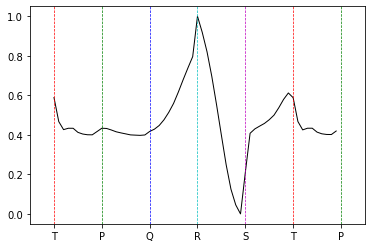

: 

In [46]:
index = 0
segement_number = 10
ECG_values = np.zeros([6,segement_number])


for index in range(test_dataset.__len__()):#
    ECG_value = np.zeros([6,segement_number])
    inputs,labels = test_dataset.__getitem__(index)
    info =test_dataset.infos.iloc[index]
    ECGfile_name = info['ECGFilename']
    layervalue_file = layervalue_root  + ECGfile_name +'.npy'
    waves_location_file_root = '/workspace/data/Preprocess_HTN/Waves_2023/'
    waves = pd.read_csv(waves_location_file_root+ECGfile_name+'.csv',index_col=0)
    if(waves.isnull().any().any()):
        continue
    # layervalue = np.load(layervalue_file)
    layervalue = np.array(inputs)
    for head_peak in range(1,len(waves.columns)-1):
        if(waves.loc['P'][head_peak] == waves.iloc[:,head_peak].min()): #P波不是第一个识别出来的波形
            p_index = int(waves.loc['P'][head_peak])
            q_index = int(waves.loc['Q'][head_peak])
            r_index = int(waves.loc['R'][head_peak])
            s_index = int(waves.loc['S'][head_peak])
            t_index = int(waves.loc['T'][head_peak])
            t_index_befort = int(waves.loc['T'][head_peak-1])
            if(((waves.loc['P'][head_peak+1]==None)) or((waves.loc['P'][head_peak+1] < t_index))):
                break
            else:
                p_index_next = waves.loc['P'][head_peak+1] 
            ECG_value[0] = ECG_value[0]+ layervalue_segement_count(t_index_befort,p_index,layervalue,segement_number)
            ECG_value[1] = ECG_value[1]+ layervalue_segement_count(p_index,q_index,layervalue,segement_number)   
            ECG_value[2] = ECG_value[2]+ layervalue_segement_count(q_index,r_index,layervalue,segement_number) 
            ECG_value[3] = ECG_value[3]+layervalue_segement_count(r_index,s_index,layervalue,segement_number)
            ECG_value[4] = ECG_value[4]+ layervalue_segement_count(s_index,t_index,layervalue,segement_number) 
            ECG_value[5] = ECG_value[5]+ layervalue_segement_count(t_index,p_index_next,layervalue,segement_number) 
        else:
            break
    ECG_value = max_min(ECG_value)
    ECG_values = ECG_value + ECG_value
X_lable = ['0','T','P','Q','R','S','T','P','']
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(ECG_values.flatten().__len__()), max_min(ECG_values.flatten()), lw=1,color='k')
ax.axvline(x=0,ls='dashed',lw=0.7,color='r')
ax.axvline(x=10,ls='dashed',lw=0.7,color='g')
ax.axvline(x=20,ls='dashed',lw=0.7,color='b')
ax.axvline(x=30,ls='dashed',lw=0.7,color='c')
ax.axvline(x=40,ls='dashed',lw=0.7,color='m')
ax.axvline(x=50,ls='dashed',lw=0.7,color='r')
ax.axvline(x=60,ls='dashed',lw=0.7,color='g')
ax.set_xlim(-5,65)
ax.set_xticklabels(X_lable)

/workspace/data/Interpretable_HTN/model/20230216_132044/20230216_132044/parameter_EarlyStoping_0//Occlusion/20-43338.npy  not exit
/workspace/data/Interpretable_HTN/model/20230216_132044/20230216_132044/parameter_EarlyStoping_0//Occlusion/21-10-3704.npy  not exit
/workspace/data/Interpretable_HTN/model/20230216_132044/20230216_132044/parameter_EarlyStoping_0//Occlusion/00-1-629.npy  not exit
/workspace/data/Interpretable_HTN/model/20230216_132044/20230216_132044/parameter_EarlyStoping_0//Occlusion/22-39707.npy  not exit
/workspace/data/Interpretable_HTN/model/20230216_132044/20230216_132044/parameter_EarlyStoping_0//Occlusion/00-1-146.npy  not exit
/workspace/data/Interpretable_HTN/model/20230216_132044/20230216_132044/parameter_EarlyStoping_0//Occlusion/00-1-145.npy  not exit
/workspace/data/Interpretable_HTN/model/20230216_132044/20230216_132044/parameter_EarlyStoping_0//Occlusion/00-1-549.npy  not exit
/workspace/data/Interpretable_HTN/model/20230216_132044/20230216_132044/parameter

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


[Text(-10.0, 0, '0'),
 Text(0.0, 0, 'T'),
 Text(10.0, 0, 'P'),
 Text(20.0, 0, 'Q'),
 Text(30.0, 0, 'R'),
 Text(40.0, 0, 'S'),
 Text(50.0, 0, 'T'),
 Text(60.0, 0, 'P'),
 Text(70.0, 0, '')]

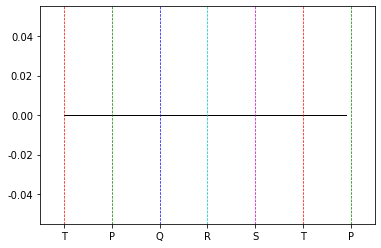

In [32]:
index = 0
segement_number = 10
important_values = np.zeros([6,segement_number])
Occlusion_root = save_root+'/Occlusion/'

for index in range(test_dataset.__len__()):#
    important_value = np.zeros([6,segement_number])
    inputs,labels = test_dataset.__getitem__(index)
    if(labels == 0) :continue
    info =test_dataset.infos.iloc[index]
    ECGfile_name = info['ECGFilename']
    layervalue_file = Occlusion_root  + ECGfile_name +'.npy'
    waves_location_file_root = '/workspace/data/Preprocess_HTN/Waves_2023/'
    if(not os.path.exists(layervalue_file)):
        print(layervalue_file," not exit")
        continue
    waves = pd.read_csv(waves_location_file_root+ECGfile_name+'.csv',index_col=0)
    if(waves.isnull().any().any()):
        continue
    layervalue = np.load(layervalue_file)

    for head_peak in range(1,len(waves.columns)-1):
        if(waves.loc['P'][head_peak] == waves.iloc[:,head_peak].min()): #P波不是第一个识别出来的波形
            p_index = int(waves.loc['P'][head_peak])
            q_index = int(waves.loc['Q'][head_peak])
            r_index = int(waves.loc['R'][head_peak])
            s_index = int(waves.loc['S'][head_peak])
            t_index = int(waves.loc['T'][head_peak])
            t_index_befort = int(waves.loc['T'][head_peak-1])
            if(((waves.loc['P'][head_peak+1]==None)) or((waves.loc['P'][head_peak+1] < t_index))):
                break
            else:
                p_index_next = waves.loc['P'][head_peak+1] 
            important_value[0] = important_value[0]+ layervalue_segement_count(t_index_befort,p_index,layervalue,segement_number)
            important_value[1] = important_value[1]+ layervalue_segement_count(p_index,q_index,layervalue,segement_number)   
            important_value[2] = important_value[2]+ layervalue_segement_count(q_index,r_index,layervalue,segement_number) 
            important_value[3] = important_value[3]+layervalue_segement_count(r_index,s_index,layervalue,segement_number)
            important_value[4] = important_value[4]+ layervalue_segement_count(s_index,t_index,layervalue,segement_number) 
            important_value[5] = important_value[5]+ layervalue_segement_count(t_index,p_index_next,layervalue,segement_number) 
        else:
            break
    important_value = max_min(important_value)
    important_values = important_values + important_value
X_lable = ['0','T','P','Q','R','S','T','P','']
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(important_values.flatten().__len__()), max_min(important_values.flatten()), lw=1,color='k')
ax.axvline(x=0,ls='dashed',lw=0.7,color='r')
ax.axvline(x=10,ls='dashed',lw=0.7,color='g')
ax.axvline(x=20,ls='dashed',lw=0.7,color='b')
ax.axvline(x=30,ls='dashed',lw=0.7,color='c')
ax.axvline(x=40,ls='dashed',lw=0.7,color='m')
ax.axvline(x=50,ls='dashed',lw=0.7,color='r')
ax.axvline(x=60,ls='dashed',lw=0.7,color='g')
ax.set_xlim(-5,65)
ax.set_xticklabels(X_lable)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


[Text(-10.0, 0, '0'),
 Text(0.0, 0, 'T'),
 Text(10.0, 0, 'P'),
 Text(20.0, 0, 'Q'),
 Text(30.0, 0, 'R'),
 Text(40.0, 0, 'S'),
 Text(50.0, 0, 'T'),
 Text(60.0, 0, 'P'),
 Text(70.0, 0, '')]

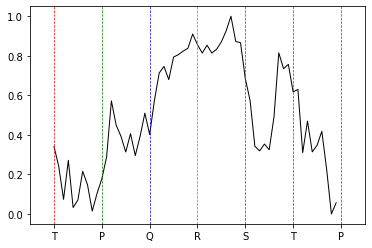

In [12]:
index = 0
segement_number = 10
important_values = np.zeros([6,segement_number])
Occlusion_root = save_root+'/Occlusion/'

for index in range(test_dataset.__len__()):#
    important_value = np.zeros([6,segement_number])
    inputs,labels = test_dataset.__getitem__(index)
    if(labels == 1) :continue
    info =test_dataset.infos.iloc[index]
    ECGfile_name = info['ECGFilename']
    layervalue_file = Occlusion_root  + ECGfile_name +'.npy'
    waves_location_file_root = '/workspace/data/Preprocess_HTN/Waves_2023/'
    if(not os.path.exists(layervalue_file)):
        print(layervalue_file," not exit")
        continue
    waves = pd.read_csv(waves_location_file_root+ECGfile_name+'.csv',index_col=0)
    if(waves.isnull().any().any()):
        continue
    layervalue = np.load(layervalue_file)

    for head_peak in range(1,len(waves.columns)-1):
        if(waves.loc['P'][head_peak] == waves.iloc[:,head_peak].min()): #P波不是第一个识别出来的波形
            p_index = int(waves.loc['P'][head_peak])
            q_index = int(waves.loc['Q'][head_peak])
            r_index = int(waves.loc['R'][head_peak])
            s_index = int(waves.loc['S'][head_peak])
            t_index = int(waves.loc['T'][head_peak])
            t_index_befort = int(waves.loc['T'][head_peak-1])
            if(((waves.loc['P'][head_peak+1]==None)) or((waves.loc['P'][head_peak+1] < t_index))):
                break
            else:
                p_index_next = waves.loc['P'][head_peak+1] 
            important_value[0] = important_value[0]+ layervalue_segement_count(t_index_befort,p_index,layervalue,segement_number)
            important_value[1] = important_value[1]+ layervalue_segement_count(p_index,q_index,layervalue,segement_number)   
            important_value[2] = important_value[2]+ layervalue_segement_count(q_index,r_index,layervalue,segement_number) 
            important_value[3] = important_value[3]+layervalue_segement_count(r_index,s_index,layervalue,segement_number)
            important_value[4] = important_value[4]+ layervalue_segement_count(s_index,t_index,layervalue,segement_number) 
            important_value[5] = important_value[5]+ layervalue_segement_count(t_index,p_index_next,layervalue,segement_number) 
        else:
            break
    important_value = max_min(important_value)
    important_values = important_values + important_value
X_lable = ['0','T','P','Q','R','S','T','P','']
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(important_values.flatten().__len__()), max_min(important_values.flatten()), lw=1,color='k')
ax.axvline(x=0,ls='dashed',lw=0.7,color='r')
ax.axvline(x=10,ls='dashed',lw=0.7,color='g')
ax.axvline(x=20,ls='dashed',lw=0.7,color='b')
ax.axvline(x=30,ls='dashed',lw=0.7,color='c')
ax.axvline(x=40,ls='dashed',lw=0.7,color='m')
ax.axvline(x=50,ls='dashed',lw=0.7,color='r')
ax.axvline(x=60,ls='dashed',lw=0.7,color='g')
ax.set_xlim(-5,65)
ax.set_xticklabels(X_lable)

----------------------------

GRU：2 ATT  batchsize：64

In [ ]:
np.array([0.3512900727135794, 0.3734808053289141, 0.3555836294378553, 0.3445756807923317, 0.34377362579107285]).mean() #logs/20230212_134040/log.log

In [ ]:
np.array([0.8434311224489796, 0.8252060439560439, 0.852782392026578, 0.861328125, 0.864453125] ).mean() 

-----------------

3 layer GRU  batchsize = 64

In [ ]:
np.array([0.34137497203690664, 0.419583329132625, 0.2343021673815591, 0.3741154298186302, 0.2929470892995596]).mean()  #/logs/20230211_171822/log.log    3 layer GRU  batchsize = 64

In [ ]:
np.array([0.8499453352769679, 0.823489010989011, 0.9052637043189369, 0.8460582386363636, 0.88359375]).mean()  

In [ ]:
np.array([0.9523809523809523,0.8523809523809524,0.9790575916230366,0.8393574297188755,0.8310344827586207]).mean()  #precision

In [ ]:
np.array([0.7339449541284404,0.7955555555555556,0.8385650224215246, 0.8565573770491803,0.8763636363636363]).mean()  #recall

------------

2 layer GRU  batchsize = 128

In [ ]:
np.array([0.32283543795347214, 0.44184040278196335, 0.29647157341241837, 0.4000786542892456, 0.342408150434494]).mean() # vlogs/20230211_072050/log.log   2 layer GRU  batchsize = 128

In [ ]:
np.array([0.8651147959183674, 0.794921875, 0.8811319040697674, 0.8361458333333334, 0.8776041666666666] ).mean() 

----------

 2 layer GRU  batchsize = 64

In [ ]:
np.array( [0.3219981959887913, 0.3934356187071119, 0.28491889366081785, 0.33339295722544193, 0.3012485932558775]).mean()  # logs/20230212_031236/log.log

In [ ]:
np.array([0.8693513119533528, 0.835679945054945, 0.8918708471760797, 0.869140625, 0.88828125] ).mean() 

In [ ]:
np.array([0.9497206703910615, 0.8768472906403941,0.9538461538461539,0.9447236180904522,0.8988326848249028]).mean()  #precision

In [ ]:
np.array( [0.7798165137614679,0.7911111111111111, 0.8340807174887892, 0.7704918032786885,0.8884615384615384]).mean()  #recall

GradientShap

In [ ]:
NET = [Net.MLBFNet_GUR_o(True,True,True,2,Dropout_rate=0.3) ] # type: ignore
testmodel = NET[0].to(DEVICE)
Models_path = '/workspace/data/Interpretable_HTN/model/20230212_031236/20230212_031236/parameter_EarlyStoping_4.pt'
save_root = Models_path[:-3]+'/'
layervalue_root = save_root+'/layervalue/'
testmodel.load_state_dict(torch.load(Models_path))

In [ ]:
def predict(data,testmodel):
    testmodel.eval()
    output = testmodel(data)
    porbs = torch.nn.functional.softmax(output)
    return porbs

In [ ]:
inputs,labels = test_dataset.__getitem__(index)
info =test_dataset.infos.iloc[index]
ECGfile_name = info['ECGFilename']
testmodel.eval()
inputs = inputs.unsqueeze(0)
inputs = inputs.to(DEVICE)
labels = labels.to(DEVICE)  
predict(inputs,testmodel)

In [ ]:
labels

In [ ]:
from captum.attr import GradientShap
from captum.attr import visualization as viz

In [ ]:
gradient_shap = GradientShap(testmodel)

In [ ]:
rand_img_dist = torch.cat([inputs * 0, inputs * 1])

In [ ]:
rand_img_dist.shape

In [ ]:
attributions_gs = gradient_shap.attribute(inputs,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=labels)


In [ ]:
attributions_gs.shape

遮挡可解释性分析

In [ ]:
from captum.attr import Occlusion
from captum.attr import visualization as viz

In [ ]:
occlusion = Occlusion(testmodel)

In [ ]:
save_root = Models_path[:-3]+'/'
Occlusion_root = save_root+'/Occlusion/'
if(not(os.path.exists(save_root))): os.mkdir(save_root)
if(not(os.path.exists(Occlusion_root))): os.mkdir(Occlusion_root)
lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
x_index = np.arange(0,12)
# fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True,sharey=True,figsize=(45,25), constrained_layout=True,dpi =100)
for index in tqdm(range(test_dataset.__len__())):#test_dataset.__len__()
    
    inputs,labels = test_dataset.__getitem__(index)
    info =test_dataset.infos.iloc[index]
    inputs = inputs.unsqueeze(0)
    ECGfile_name = info['ECGFilename']
    attributions_occ = occlusion.attribute(inputs,
                                        strides = (1, 10), # 遮挡滑动移动步长
                                        target=labels, # 目标类别
                                        sliding_window_shapes=(12, 20), # 遮挡滑块尺寸
                                        baselines=0)
    Occlusion_vlue = attributions_occ.squeeze(0).numpy()
    np.save(Occlusion_root+ECGfile_name,Occlusion_vlue)

In [ ]:
layer2d_vlue = attributions_occ.squeeze(0).numpy()
lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
x_index = np.arange(0,12)
fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True,sharey=True,figsize=(45,25), constrained_layout=True,dpi =100)
ecg_data,_ = test_dataset.__getitem__(index)

cmap = 'OrRd' 
colors = ECGplot.color_map(layer2d_vlue, cmap)#相当于归一化

for i,ax in enumerate(axs.flat):  # type: ignore
    plot_y = np.array(ecg_data[i]*5000.)#缩放
    t = np.arange(0,5000)
    ECGplot.plot_ECG_line(fig,ax,x = t,y= plot_y,y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i])
    for j in t:
        ax.axvline(x=j,alpha=0.1,color=colors[i,j]) #第i导联 第j个时间点的importance value